In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Model performance evaluation: AUROC and average precision (AP) scores and f1 score from sklearn
from sklearn.metrics import roc_auc_score, average_precision_score,accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import f1_score

In [ ]:
from datetime import datetime
from datetime import timedelta, date

In [ ]:
static = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TeamShare/ProcessedData/preprocessed_staticFeatures_SB.csv',index_col='patient')
dynamic = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TeamShare/ProcessedData/7 Dynamic_Final.csv',index_col='patient')
y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TeamShare/ProcessedData/preprocessed_labels_SB.csv',index_col='patient')

import pickle

with open('/content/drive/My Drive/Colab Notebooks/TeamShare/ProcessedData/text_dataframe.pkl', 'rb') as f:
    notes_data = pickle.load(f)
notes_data.rename(columns={'id': 'patient'}, inplace=True)
notes_data.set_index('patient', inplace=True)
with open('/content/drive/My Drive/Colab Notebooks/TeamShare/ProcessedData/TF-IDF.pkl', 'rb') as f:
    notes_tfid = pickle.load(f)

In [ ]:
#EB added: dump lab values that are the same just in diff units or with known transformation
  #over very highly correlated (did VIF in other notebook)
print(dynamic.shape)

cols_to_drop = ['hematocrit', 'mch', 'rbc']
dynamic.drop(cols_to_drop, axis=1, inplace=True)

print(dynamic.shape)

(56150, 19)
(56150, 16)


In [ ]:
# filter out any patients that don't have timeseries
ts_patients = [x for x in dynamic.index.unique()]
static = static.loc[ts_patients].copy()
y = y.loc[ts_patients].copy()
sel = np.where(notes_data.index.isin(ts_patients))[0]
notes_tfid = notes_tfid[sel].copy()
notes_data = notes_data.loc[ts_patients].copy()

In [ ]:
y = y[y.los_icu < y.los_icu.quantile(.99)].copy()

In [ ]:
# Pivot the DataFrame to convert long to wide
dynamic = dynamic.pivot(columns='time_slot')
# Flatten the multi-level column index
dynamic.columns = [f'{col[0]}_{col[1]}' for col in dynamic.columns]

In [ ]:
dynamic

,aniongap_1,aniongap_2,aniongap_3,aniongap_4,bicarbonate_1,bicarbonate_2,bicarbonate_3,bicarbonate_4,bun_1,bun_2,...,platelet_3,platelet_4,rdw_1,rdw_2,rdw_3,rdw_4,wbc_1,wbc_2,wbc_3,wbc_4
patient,,,,,,,,,,,,,,,,,,,,,
20001305,-0.120654,-0.534140,-0.534140,-0.534140,0.117566,0.499282,0.499282,0.308424,0.470452,0.508936,...,0.108619,0.037785,0.144165,0.094051,0.094051,0.134085,-0.157610,-0.158146,-0.158146,-0.186103
20001361,-0.120654,-0.120654,-0.120654,0.499576,-0.455009,0.117566,0.117566,0.117566,-0.106806,0.047129,...,0.370844,0.370844,-1.093515,-0.925318,-0.925318,-0.925318,0.419186,0.428295,0.428295,0.428295
20001770,-0.327397,-0.327397,NaN,NaN,-0.073293,-0.073293,NaN,NaN,-0.453161,-0.453161,...,NaN,NaN,1.849940,1.849940,NaN,NaN,0.054828,0.054828,NaN,NaN
20002506,0.086090,0.086090,0.086090,-0.327397,-0.073293,-0.073293,-0.073293,-0.073293,-0.838000,-0.838000,...,0.209252,-0.221661,-1.682206,-1.682206,-1.682206,-1.598107,-0.227548,-0.227548,-0.227548,-0.446163
20003425,-0.534140,-0.947626,NaN,NaN,-0.264151,-0.264151,NaN,NaN,-0.453161,-0.453161,...,NaN,NaN,-0.084331,-0.042281,NaN,NaN,-0.273093,-0.291311,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996630,0.499576,-0.120654,NaN,NaN,-1.027584,-0.264151,NaN,NaN,-0.722548,-0.684064,...,NaN,NaN,-0.504824,-0.630972,NaN,NaN,-0.172895,0.027502,NaN,NaN
29997500,0.086090,0.086090,-0.120654,NaN,1.644431,1.644431,2.026148,NaN,-0.453161,-0.453161,...,-0.679505,NaN,0.072863,0.072863,1.008953,NaN,-0.159585,-0.159585,-0.254875,NaN
29997616,0.706319,0.706319,0.706319,0.499576,0.308424,0.308424,0.308424,0.117566,-1.068903,-1.068903,...,0.936416,0.864597,-0.630972,-0.630972,-0.630972,-0.588923,0.200571,0.200571,0.200571,0.701563


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
dynamic_KNN = imputer.fit_transform(dynamic)

In [ ]:
dynamic_KNN

array([[-0.12065358, -0.53414002, -0.53414002, ..., -0.15814632,
        -0.15814632, -0.18610291],
       [-0.12065358, -0.12065358, -0.12065358, ...,  0.4282946 ,
         0.4282946 ,  0.4282946 ],
       [-0.3273968 , -0.3273968 , -1.19571831, ...,  0.05482839,
        -0.36600426, -0.34232104],
       ...,
       [ 0.70631928,  0.70631928,  0.70631928, ...,  0.2005713 ,
         0.2005713 ,  0.70156256],
       [ 0.9130625 ,  0.9130625 , -0.12065358, ..., -0.10881395,
        -0.17370974, -0.19880698],
       [ 0.29283285,  0.29283285, -0.12065358, ...,  0.17324451,
         0.31898742,  0.31898742]])

In [ ]:
dynamic_KNN_df = pd.DataFrame(dynamic_KNN, index=dynamic.index, columns=dynamic.columns)

In [ ]:
dynamic_KNN_df

,aniongap_1,aniongap_2,aniongap_3,aniongap_4,bicarbonate_1,bicarbonate_2,bicarbonate_3,bicarbonate_4,bun_1,bun_2,...,platelet_3,platelet_4,rdw_1,rdw_2,rdw_3,rdw_4,wbc_1,wbc_2,wbc_3,wbc_4
patient,,,,,,,,,,,,,,,,,,,,,
20001305,-0.120654,-0.534140,-0.534140,-0.534140,0.117566,0.499282,0.499282,0.308424,0.470452,0.508936,...,0.108619,0.037785,0.144165,0.094051,0.094051,0.134085,-0.157610,-0.158146,-0.158146,-0.186103
20001361,-0.120654,-0.120654,-0.120654,0.499576,-0.455009,0.117566,0.117566,0.117566,-0.106806,0.047129,...,0.370844,0.370844,-1.093515,-0.925318,-0.925318,-0.925318,0.419186,0.428295,0.428295,0.428295
20001770,-0.327397,-0.327397,-1.195718,-0.368745,-0.073293,-0.073293,-0.035121,0.117566,-0.453161,-0.453161,...,-0.787233,-0.316821,1.849940,1.849940,1.067822,0.630508,0.054828,0.054828,-0.366004,-0.342321
20002506,0.086090,0.086090,0.086090,-0.327397,-0.073293,-0.073293,-0.073293,-0.073293,-0.838000,-0.838000,...,0.209252,-0.221661,-1.682206,-1.682206,-1.682206,-1.598107,-0.227548,-0.227548,-0.227548,-0.446163
20003425,-0.534140,-0.947626,-0.451443,-0.244700,-0.264151,-0.264151,-0.073293,0.155737,-0.453161,-0.453161,...,-0.142660,0.347503,-0.084331,-0.042281,-0.403906,-0.042281,-0.273093,-0.291311,-0.422480,0.156848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996630,0.499576,-0.120654,-0.120654,-0.037956,-1.027584,-0.264151,-0.416837,-0.607696,-0.722548,-0.684064,...,0.055055,-0.176774,-0.504824,-0.630972,-0.755370,-0.504824,-0.172895,0.027502,-0.205426,-0.211152
29997500,0.086090,0.086090,-0.120654,-0.451443,1.644431,1.644431,2.026148,2.217006,-0.453161,-0.453161,...,-0.679505,0.448049,0.072863,0.072863,1.008953,0.033408,-0.159585,-0.159585,-0.254875,-0.198400
29997616,0.706319,0.706319,0.706319,0.499576,0.308424,0.308424,0.308424,0.117566,-1.068903,-1.068903,...,0.936416,0.864597,-0.630972,-0.630972,-0.630972,-0.588923,0.200571,0.200571,0.200571,0.701563


In [ ]:
# Create separate lists for each group of columns
col1 = [col for col in dynamic_KNN_df.columns if col.endswith('_1')]
col2 = [col for col in dynamic_KNN_df.columns if col.endswith('_2')]
col3 = [col for col in dynamic_KNN_df.columns if col.endswith('_3')]
col0 = [col for col in dynamic_KNN_df.columns if col.endswith('_4')]

# Reorder the columns
dynamic_KNN_df = dynamic_KNN_df[col1 + col2 + col3 + col0]

dynamic_KNN_df

,aniongap_1,bicarbonate_1,bun_1,calcium_1,chloride_1,creatinine_1,glucose_1,sodium_1,potassium_1,hemoglobin_1,...,creatinine_4,glucose_4,sodium_4,potassium_4,hemoglobin_4,mchc_4,mcv_4,platelet_4,rdw_4,wbc_4
patient,,,,,,,,,,,,,,,,,,,,,
20001305,-0.120654,0.117566,0.470452,3.585920,0.639491,-0.605244,0.039963,0.692532,-0.020649,0.019966,...,-0.556630,-0.253067,0.519073,-0.282995,0.006977,0.034670,-0.009290,0.037785,0.134085,-0.186103
20001361,-0.120654,-0.455009,-0.106806,-2.004458,0.639491,0.221204,-0.342250,-0.174763,1.815772,0.961336,...,0.804580,-0.354990,1.039450,-0.676513,1.010296,0.928291,-0.341379,0.370844,-0.925318,0.428295
20001770,-0.327397,-0.073293,-0.453161,-0.977654,-2.387933,-0.362171,-0.902828,-2.776647,0.241697,-0.213707,...,-0.449678,-0.268355,-2.741955,0.267931,-0.135370,1.127375,0.754437,-0.316821,0.630508,-0.342321
20002506,0.086090,-0.073293,-0.838000,1.190044,-0.323780,-0.653859,-0.648020,0.172155,-0.282995,1.744697,...,-0.653859,-0.724462,1.039450,-0.414168,1.157176,0.342750,-0.204402,-0.221661,-1.598107,-0.446163
20003425,-0.534140,-0.264151,-0.453161,0.391418,-0.599000,-0.556630,-0.214845,-0.868599,0.897561,-1.290829,...,-0.342725,0.154627,-0.591064,0.608981,-0.957900,-0.781490,0.151738,0.347503,-0.042281,0.156848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996630,0.499576,-1.027584,-0.722548,-0.749475,-0.186170,-0.508015,2.995741,-0.174763,-0.151822,1.206136,...,-0.235773,0.264195,-0.244147,-0.125587,-0.017866,0.494990,-0.724915,-0.176774,-0.504824,-0.211152
29997500,0.086090,1.644431,-0.453161,1.075954,-1.424661,-0.508015,-0.380471,0.345614,-0.151822,0.014378,...,-0.537184,-0.334605,0.449689,-0.545340,0.089846,-0.430165,0.014761,0.448049,0.033408,-0.198400
29997616,0.706319,0.308424,-1.068903,0.733686,-0.186170,-0.653859,-0.648020,0.519073,-0.676513,1.353016,...,-0.605244,0.141886,0.172155,0.635216,1.108216,-1.003995,-0.615333,0.864597,-0.588923,0.701563


In [ ]:
notes = pd.DataFrame(notes_tfid, index=notes_data.index)

In [ ]:
df = pd.merge(static, dynamic_KNN_df, on = 'patient')
df = pd.merge(df, notes, on = 'patient')
df

,gender,admission_age,weight_admit,height,charlson_score,atrial_fibrillation,malignant_cancer,chf,ckd,cld,...,90,91,92,93,94,95,96,97,98,99
patient,,,,,,,,,,,,,,,,,,,,,
20001305,0,1.093628,-1.464727,-1.335937,2.130287,0,0,0,0,0,...,0.000000,0.151338,0.040729,0.071079,0.098968,0.038111,0.116614,0.035512,0.000000,0.040249
20001361,1,-2.363275,0.583513,1.253461,-1.986889,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.054632,0.025356,0.000000,0.143410,0.109180,0.027600,0.000000
20001770,0,-2.059891,-0.779626,0.000000,-0.957595,0,0,0,0,0,...,0.037577,0.100197,0.040449,0.000000,0.032762,0.000000,0.231622,0.070535,0.035662,0.039971
20002506,1,-2.756136,-0.899696,0.000000,-0.957595,0,0,0,0,0,...,0.000000,0.023156,0.018696,0.048940,0.075715,0.052481,0.171293,0.065204,0.164831,0.036950
20003425,1,0.601206,-0.451202,0.000000,2.130287,0,1,0,0,0,...,0.127608,0.000000,0.027472,0.047942,0.066753,0.025706,0.125850,0.047905,0.000000,0.081443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996630,0,-0.723692,1.007287,-0.873545,-1.300693,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049722,0.000000,0.000000,0.171612
29997500,0,0.268247,0.403409,0.000000,2.130287,0,1,1,1,0,...,0.125525,0.000000,0.022519,0.000000,0.036480,0.000000,0.206325,0.019635,0.019854,0.044507
29997616,1,-1.178308,0.753023,0.000000,-1.986889,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.162865,0.000000,0.000000,0.000000


In [ ]:
full_df = pd.merge(df, y, on = 'patient')

In [ ]:
full_df['los_icu'].quantile(q=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.25     1.8200
0.50     2.8900
0.75     5.2400
0.90    10.1000
0.95    14.2770
0.99    24.1202
Name: los_icu, dtype: float64

In [ ]:
from sklearn.utils import shuffle
full_df = shuffle(full_df, random_state = 9)

In [ ]:
X_df = df.loc[full_df.index].to_numpy()
X_df

array([[ 0.        ,  1.22654631,  0.44931796, ...,  0.        ,
         0.05534461,  0.06203312],
       [ 1.        ,  1.55348221, -1.30581227, ...,  0.07676986,
         0.05175206,  0.0290032 ],
       [ 1.        , -2.13597545,  0.01848117, ...,  0.        ,
         0.        ,  0.08440506],
       ...,
       [ 1.        ,  0.8974749 , -0.1298397 , ...,  0.        ,
         0.        ,  0.16995931],
       [ 1.        ,  0.92892768,  0.05026421, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.80789775, -0.06274216, ...,  0.        ,
         0.        ,  0.20798086]])

In [ ]:
y1_df = full_df['icu_death'].astype(int)
y2_df = full_df['los_icu']

In [ ]:
y['los_icu'].quantile(q=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

0.25     1.8200
0.50     2.8900
0.75     5.2400
0.90    10.1000
0.95    14.2770
0.99    24.1202
Name: los_icu, dtype: float64

# Non-NN based models


## Regression


In [ ]:
from sklearn.model_selection import train_test_split
# train-test split
X_train, X_val, y_train, y_val = train_test_split(X_df, y2_df, test_size=0.15, random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=9)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
lin = LinearRegression()
lin = PoissonRegressor()
rfe = RFE(lin, n_features_to_select = 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
#print(rfe.ranking_)

In [ ]:
df.columns[rfe.support_]

Index([            'weight_admit',      'atrial_fibrillation',
                            'ckd',                      'ihd',
                   'race_unk_oth',     'first_careunit_CVICU',
            'first_careunit_SICU',     'first_careunit_TSICU',
        'admission_type_elective', 'admission_type_emergency',
                     'nullheight',                'calcium_1',
                   'creatinine_1',               'aniongap_3',
                          'bun_3',                'glucose_3',
                       'sodium_3',                    'wbc_4',
                               82,                         87],
      dtype='object')

In [ ]:
lin = PoissonRegressor()
lin.fit(X_train, y_train)
y_pred_train = lin.predict(X_train)
y_pred_test = lin.predict(X_test)
y_pred_val = lin.predict(X_val)
from sklearn.metrics import r2_score
print("Linear Regression R squared of the train set is: {:.2f}".format(r2_score(y_train, y_pred_train)))
print("Linear Regression R squared of the test set is: {:.2f}".format(r2_score(y_test, y_pred_test)))

Linear Regression R squared of the train set is: 0.11
Linear Regression R squared of the test set is: 0.10


In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test)
print("Linear Regression MSE of the train set is: {:.2f}".format(mean_squared_error(y_train, y_pred_train)))
print("Linear Regression MSE of the test set is: {:.2f}".format(mean_squared_error(y_test, y_pred_test)))
print("Linear Regression MSE of the val set is: {:.2f}".format(mean_squared_error(y_val, y_pred_val)))

Linear Regression MSE of the train set is: 18.60
Linear Regression MSE of the test set is: 20.50
Linear Regression MSE of the val set is: 18.10


In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred_test)
print("Linear Regression MAE of the train set is: {:.2f}".format(mean_absolute_error(y_train, y_pred_train)))
print("Linear Regression MAE of the test set is: {:.2f}".format(mean_absolute_error(y_test, y_pred_test)))
print("Linear Regression MAE of the val set is: {:.2f}".format(mean_absolute_error(y_val, y_pred_val)))

Linear Regression MAE of the train set is: 2.85
Linear Regression MAE of the test set is: 2.97
Linear Regression MAE of the val set is: 2.84


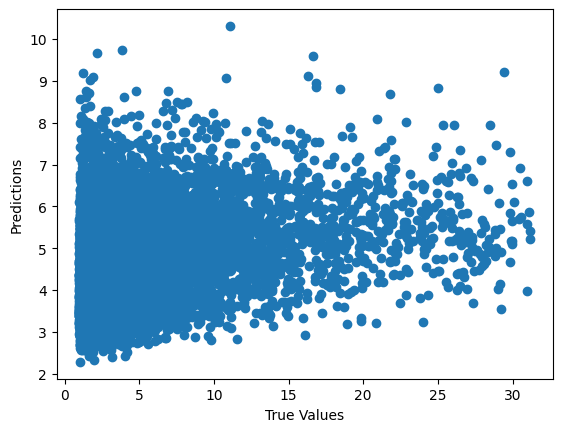

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_train, y_pred_train)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# NN based models

## Unitask Modeling: LOS(num)


In [ ]:
import torch
import torch.nn as nn


X_tensor = torch.tensor(X_df, dtype=torch.float32)
y_tensor_mort = torch.tensor(y1_df.to_numpy(), dtype=torch.float32)
y_tensor_los = torch.tensor(y2_df.to_numpy(), dtype=torch.float32)

BATCH_SIZE = 64
LEARNING_RATE = 0.001
INPUT_SIZE = X_tensor.shape[1]

# train-test split
train_split = int(0.85 * len(X_tensor))
X_train, y_train_mort, y_train_los = X_tensor[:train_split], y_tensor_mort[:train_split], y_tensor_los[:train_split]
X_val, y_val_mort, y_val_los = X_tensor[train_split:], y_tensor_mort[train_split:], y_tensor_los[train_split:]

train_split = int(0.85 * len(X_train))
X_test, y_test_mort, y_test_los = X_train[train_split:], y_train_mort[train_split:], y_train_los[train_split:]
X_train, y_train_mort, y_train_los = X_train[:train_split], y_train_mort[:train_split], y_train_los[:train_split]



train_loader = torch.utils.data.DataLoader(X_train,
                                           batch_size= BATCH_SIZE,
                                           shuffle=True)

In [ ]:
torch.manual_seed(9)
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size=1):

        self.hidden_linear1 =32
        self.hidden_linear2 =16

        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, self.hidden_linear1)
        self.layer2 = nn.Linear(self.hidden_linear1, self.hidden_linear2)
        self.layer3 = nn.Linear(self.hidden_linear2, output_size)
        self.relu = nn.ReLU()

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(self.hidden_linear1)
        self.batchnorm2 = nn.BatchNorm1d(self.hidden_linear2)
        self.hardtanh = nn.Hardtanh(min_val=1, max_val=30)  # keep the end predictions between 1 and 30 days

    def forward(self, x):

        x = self.layer1(x)
        #x = self.batchnorm1(x)
        x = self.relu(x)
        #x = self.dropout1(x)
        x = self.layer2(x)
        #x = self.batchnorm2(x)
        x = self.relu(x)
        #x = self.dropout2(x)
        x = self.layer3(x)
        x = self.relu(x)
        #x = self.hardtanh(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

model_mse = NeuralNet(input_size=INPUT_SIZE).to(device)

# Specify loss function and optimizer
loss_fn =  nn.MSELoss()
optimizer = torch.optim.Adam(params= model_mse.parameters(),
                            lr=LEARNING_RATE)

In [ ]:
def training(epochs, device, model, lr, X_train, y_train_los, X_test, y_test_los, loss_fn, optimizer):
  epoch_count = []
  loss_values = []
  test_loss_values = []

  X_train, y_train_los = X_train.to(device), y_train_los.to(device)
  X_test, y_test_los = X_test.to(device), y_test_los.to(device)

  for epoch in range(epochs):
    model.train()
    y_preds = model(X_train).squeeze()
    hardtanh = nn.Hardtanh(min_val=1, max_val=30)
   # y_preds = hardtanh(y_preds)
    loss = loss_fn(y_preds, y_train_los)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.inference_mode():
      test_pred = model(X_test).squeeze()
      test_loss = loss_fn(test_pred, y_test_los)
      if epoch % 10 ==0:
        epoch_count.append(epoch)
        loss_values.append(loss.item())
        test_loss_values.append(test_loss.item())
      if epoch % 100 ==0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
  plt.plot(epoch_count, loss_values, label = "Train_Loss")
  plt.plot(epoch_count, test_loss_values, label = "Test_Loss")
  plt.title("Loss Curves")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend()

  return plt, epoch_count, loss_values, test_loss_values

Epoch: 0 | Train Loss: 41.68233 | Test Loss: 44.23314
Epoch: 100 | Train Loss: 20.59682 | Test Loss: 21.54004
Epoch: 200 | Train Loss: 18.35601 | Test Loss: 19.48315
Epoch: 300 | Train Loss: 16.48846 | Test Loss: 18.39734
Epoch: 400 | Train Loss: 15.54335 | Test Loss: 18.36786
Epoch: 500 | Train Loss: 14.65343 | Test Loss: 18.54339
Epoch: 600 | Train Loss: 13.68816 | Test Loss: 19.03435
Epoch: 700 | Train Loss: 12.63700 | Test Loss: 19.74357
Epoch: 800 | Train Loss: 11.59161 | Test Loss: 20.64560
Epoch: 900 | Train Loss: 10.53539 | Test Loss: 21.57513


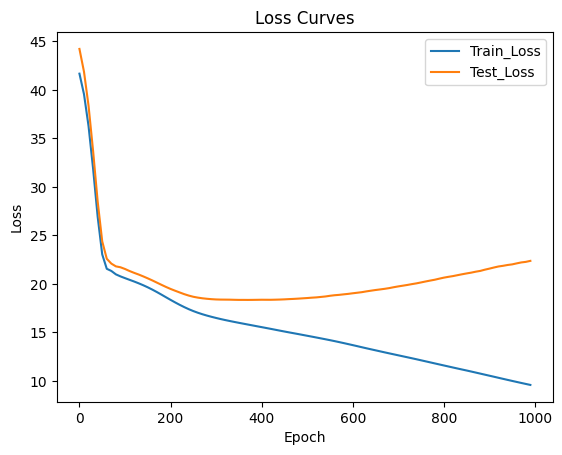

In [ ]:
plt, epoch_count, loss_values, test_loss_values = training(epochs = 1000, device = device, model = model_mse, lr = LEARNING_RATE,
                                                           X_train = X_train, y_train_los = y_train_los, X_test = X_test, y_test_los = y_test_los,
                                                           loss_fn = loss_fn, optimizer = optimizer)

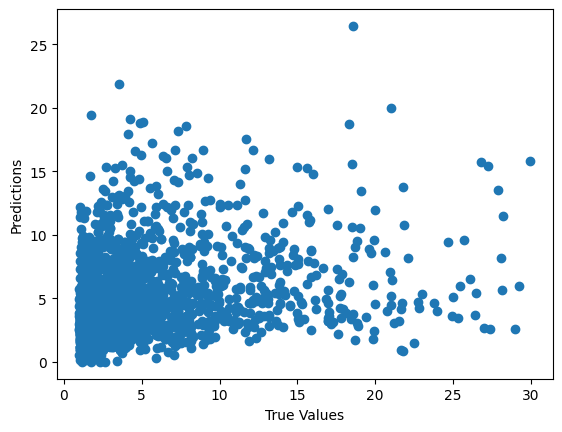

In [ ]:
import matplotlib.pyplot as plt
with torch.inference_mode():
  plt.scatter(y_test_los, model_mse(X_test))
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.show()

In [ ]:
torch.manual_seed(6001)
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size=1):
        self.hidden_linear1 =32
        self.hidden_linear2 =16

        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, self.hidden_linear1)
        self.layer2 = nn.Linear(self.hidden_linear1, self.hidden_linear2)
        self.layer3 = nn.Linear(self.hidden_linear2, output_size)
        self.relu = nn.ReLU()
        self.hardtanh = nn.Hardtanh(min_val=1, max_val=30)  # keep the end predictions between 1 and 30 days

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

model = NeuralNet(input_size=INPUT_SIZE).to(device)

# Specify loss function and optimizer
loss_fn =  nn.HuberLoss()
optimizer = torch.optim.Adam(params= model.parameters(),
                            lr=LEARNING_RATE)

Epoch: 0 | Train Loss: 3.78853 | Test Loss: 3.98075
Epoch: 100 | Train Loss: 2.27782 | Test Loss: 2.41824
Epoch: 200 | Train Loss: 2.20087 | Test Loss: 2.34396
Epoch: 300 | Train Loss: 2.08492 | Test Loss: 2.24641
Epoch: 400 | Train Loss: 1.96686 | Test Loss: 2.20881
Epoch: 500 | Train Loss: 1.86379 | Test Loss: 2.22397
Epoch: 600 | Train Loss: 1.77097 | Test Loss: 2.28060
Epoch: 700 | Train Loss: 1.69627 | Test Loss: 2.33376
Epoch: 800 | Train Loss: 1.63863 | Test Loss: 2.38079
Epoch: 900 | Train Loss: 1.59483 | Test Loss: 2.42124


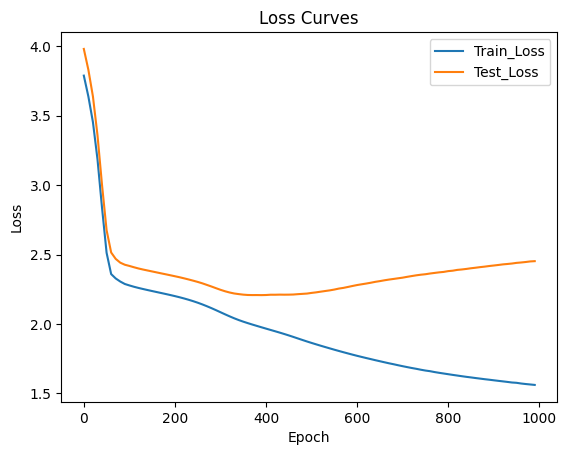

In [ ]:
plt, epoch_count, loss_values, test_loss_values = training(epochs = 1000, device = device, model = model, lr = LEARNING_RATE,
                                                           X_train = X_train, y_train_los = y_train_los, X_test = X_test, y_test_los = y_test_los,
                                                           loss_fn = loss_fn, optimizer = optimizer)

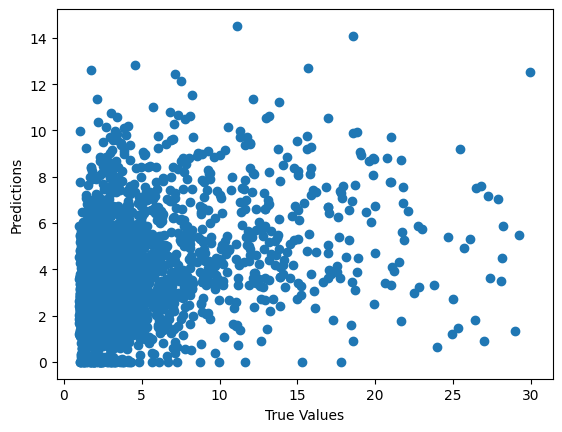

In [ ]:
import matplotlib.pyplot as plt
with torch.inference_mode():
  plt.scatter(y_test_los, model(X_test))
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.show()

## Multitask Modeling: LOS(num) + Survival

In [ ]:
import torch
import torch.nn as nn

#weight decay to help with overfitting (this can just be a default that is overridden below)
WEIGHT_DECAY = 0.01 #used 0 for overfitting
DROPOUT = 0.8
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.0001

X_tensor = torch.tensor(X_df, dtype=torch.float32)
y_tensor_mort = torch.tensor(y1_df.to_numpy(), dtype=torch.float32)
y_tensor_los = torch.tensor(y2_df.to_numpy(), dtype=torch.float32)

INPUT_SIZE = X_tensor.shape[1]

# train-test split
train_split = int(0.85 * len(X_tensor))
X_train, y_train_mort, y_train_los = X_tensor[:train_split], y_tensor_mort[:train_split], y_tensor_los[:train_split]
X_val, y_val_mort, y_val_los = X_tensor[train_split:], y_tensor_mort[train_split:], y_tensor_los[train_split:]

train_split = int(0.85 * len(X_train))
X_test, y_test_mort, y_test_los = X_train[train_split:], y_train_mort[train_split:], y_train_los[train_split:]
X_train, y_train_mort, y_train_los = X_train[:train_split], y_train_mort[:train_split], y_train_los[:train_split]

In [ ]:
import torch.nn.init as init #for weight initialization
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from statistics import mean

#EB added:
#for reproducibility: https://pytorch.org/docs/stable/notes/randomness.html
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

#EB also added this from Eric:
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

#EB alter data loader to explicitly take in y
  #https://datascience.stackexchange.com/questions/45916/loading-own-train-data-and-labels-in-dataloader-using-pytorch

train_tensors = TensorDataset(X_train, y_train_los, y_train_mort) #EB added

train_loader = torch.utils.data.DataLoader(train_tensors, #changed to train_tensors so that y is included
                                           batch_size= BATCH_SIZE,
                                           shuffle=True,
                                           worker_init_fn=seed_worker, #EB added
                                           generator=g) #EB added


In [ ]:
torch.manual_seed(9)

class Multiclass(nn.Module):
    def __init__(self, input_size, output_size=1):

        self.hidden_linear1 =32
        self.hidden_linear2 =64
        self.hidden_linear3 =256
        self.hidden_linear4 =512
        self.hidden_linear5 =256
        self.hidden_linear6 =64
        self.hidden_linear7 =32

        super(Multiclass, self).__init__()
        self.layer1 = nn.Linear(input_size, self.hidden_linear1)
        self.layer2 = nn.Linear(self.hidden_linear1, self.hidden_linear2)
        self.layer3 = nn.Linear(self.hidden_linear2,self.hidden_linear3 )
        self.layer4 = nn.Linear(self.hidden_linear3,self.hidden_linear4 )
        self.layer5 = nn.Linear(self.hidden_linear4, self.hidden_linear5)
        self.layer6 = nn.Linear(self.hidden_linear5, self.hidden_linear6)
        self.layer7 = nn.Linear(self.hidden_linear6, self.hidden_linear7)

        # Last layer for multitask prediction
        self.point_final_los = nn.Linear(self.hidden_linear7, 1)
        self.point_final_mort = nn.Linear(self.hidden_linear7, 1)

        self.relu = nn.ReLU()

        #EB added: weight intiailization
        init.xavier_normal_(self.layer1.weight)
        init.zeros_(self.layer1.bias)
        init.xavier_normal_(self.layer2.weight)
        init.zeros_(self.layer2.bias)
        init.xavier_normal_(self.layer3.weight)
        init.zeros_(self.layer3.bias)

        #EB added more
        init.xavier_normal_(self.layer4.weight)
        init.zeros_(self.layer4.bias)
        init.xavier_normal_(self.layer5.weight)
        init.zeros_(self.layer5.bias)
        init.xavier_normal_(self.layer6.weight)
        init.zeros_(self.layer6.bias)
        init.xavier_normal_(self.layer7.weight)
        init.zeros_(self.layer7.bias)

        #leaving these as constant
        self.dropout1 = nn.Dropout(p=DROPOUT)
        self.dropout2 = nn.Dropout(p=DROPOUT)

        #batch normalization
        self.batchnorm1 = nn.BatchNorm1d(self.hidden_linear1)
        self.batchnorm2 = nn.BatchNorm1d(self.hidden_linear2)
        self.batchnorm3 = nn.BatchNorm1d(self.hidden_linear3)
        self.batchnorm4 = nn.BatchNorm1d(self.hidden_linear4)
        self.batchnorm5 = nn.BatchNorm1d(self.hidden_linear5)
        self.batchnorm6 = nn.BatchNorm1d(self.hidden_linear6)
        self.batchnorm7 = nn.BatchNorm1d(self.hidden_linear7)


        self.alpha = 0.5
        self.loss_huber = nn.HuberLoss()
        self.loss_mort = nn.BCEWithLogitsLoss()
        self.hardtanh = nn.Hardtanh(min_val=1, max_val=30)  # keep the end predictions between 1 and 30 days

    def loss(self, y_hat_los, y_hat_mort, y_los, y_mort):
        los_loss =  self.loss_huber(y_hat_los, y_los)
        loss = los_loss + self.loss_mort(y_hat_mort, y_mort) * self.alpha
        return loss

    def forward(self, x):

        x = self.layer1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout2(x)

        #EB added more
        x = self.layer4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.layer5(x)
        x = self.batchnorm5(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.layer6(x)
        x = self.batchnorm6(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.layer7(x)
        x = self.batchnorm7(x)
        x = self.relu(x)
        x = self.dropout2(x)

        #end
        los_predictions = self.relu(self.point_final_los(x))
        mort_predictions = self.relu(self.point_final_mort(x))

        return los_predictions, mort_predictions


device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
model = Multiclass(input_size=INPUT_SIZE).to(device)

# Specify optimizer
optimizer = torch.optim.Adam(params= model.parameters(),
                            lr=LEARNING_RATE,
                            weight_decay = WEIGHT_DECAY)

In [ ]:

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
from sklearn.metrics import mean_squared_error
# Training
epochs = 70
epoch_count = []
loss_values = []
test_loss_values = []
MSE_values = []
test_MSE_values = []
ACC_values = []
test_ACC_values = []

# Put data to target device
X_train, y_train_los, y_train_mort = X_train.to(device), y_train_los.to(device),y_train_mort.to(device)
X_test, y_test_los, y_test_mort = X_test.to(device), y_test_los.to(device), y_test_mort.to(device)

#enumerate(train_loader)

for epoch in range(epochs):

  #EB added for batching
  sum_training_loss = 0
  acc_list = []

  #EB: adding the batching via the data loader
  for train_tensor in train_loader:
    X_train, y_train_los, y_train_mort = train_tensor
    model.train()
    y_preds_los, y_preds_mort = model(X_train)
    y_preds_los = y_preds_los.squeeze()
    y_preds_mort = y_preds_mort.squeeze()
    y_preds_mort = torch.round(torch.sigmoid(y_preds_mort))
    loss = model.loss(y_preds_los,y_preds_mort, y_train_los, y_train_mort)
    acc = accuracy_fn(y_true = y_train_mort,y_pred = y_preds_mort)
    # Aggregating loss across batches?
    sum_training_loss += loss
    acc_list.append(acc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = sum_training_loss / len(train_loader)

  # Testing
  model.eval()
  with torch.inference_mode():
    test_preds_los, test_preds_mort = model(X_test)
    test_preds_los = test_preds_los.squeeze()
    test_preds_mort = test_preds_mort.squeeze()
    test_preds_mort = torch.round(torch.sigmoid(test_preds_mort))
    test_loss = model.loss(test_preds_los,test_preds_mort, y_test_los, y_test_mort)


    if epoch % 1 ==0:
      epoch_count.append(epoch)
      loss_values.append(epoch_loss.item())
      test_loss_values.append(test_loss.item())
      mse = mean_absolute_error(y_train_los, y_preds_los)
      MSE_values.append(mse)
      test_mse = mean_absolute_error (y_test_los, test_preds_los)
      test_MSE_values.append(test_mse)
      test_acc = accuracy_fn(y_true = y_test_mort,y_pred = test_preds_mort)
      ACC_values.append(acc)
      test_ACC_values.append(test_acc)

    if epoch % 10 ==0:
      # Printing to keep track
      print(f"Epoch: {epoch} |Epoch train Loss: {epoch_loss:.5f} , MAE: {mse:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test MAE: {test_mse:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 |Epoch train Loss: 4.32592 , MAE: 4.78245, Accuracy: 29.31% | Test Loss: 4.59831, Test MAE: 4.49270, Test acc: 10.45%
Epoch: 10 |Epoch train Loss: 3.30052 , MAE: 2.85239, Accuracy: 29.31% | Test Loss: 3.26493, Test MAE: 3.07332, Test acc: 10.45%
Epoch: 20 |Epoch train Loss: 3.19623 , MAE: 2.73978, Accuracy: 13.79% | Test Loss: 3.08589, Test MAE: 2.91707, Test acc: 10.45%
Epoch: 30 |Epoch train Loss: 2.88487 , MAE: 3.38812, Accuracy: 89.66% | Test Loss: 2.80264, Test MAE: 2.89606, Test acc: 89.55%
Epoch: 40 |Epoch train Loss: 2.83026 , MAE: 2.23865, Accuracy: 87.93% | Test Loss: 2.79683, Test MAE: 2.89100, Test acc: 89.55%
Epoch: 50 |Epoch train Loss: 2.79396 , MAE: 2.57380, Accuracy: 87.93% | Test Loss: 2.79948, Test MAE: 2.89330, Test acc: 89.55%
Epoch: 60 |Epoch train Loss: 2.75763 , MAE: 3.97705, Accuracy: 84.48% | Test Loss: 2.79956, Test MAE: 2.89336, Test acc: 89.55%


In [ ]:
mse

2.6703603

In [ ]:
test_mse

2.8926198

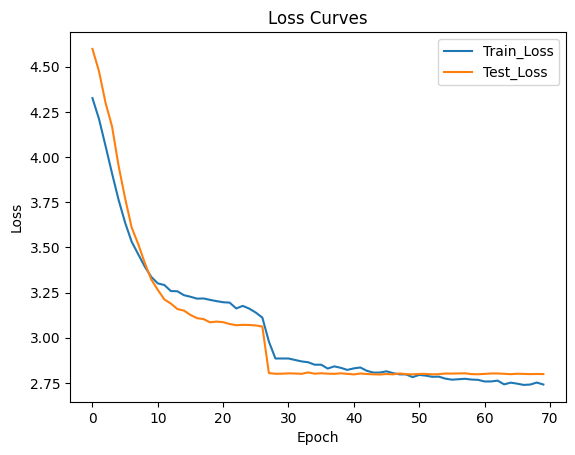

In [ ]:
# Plotting
plt.plot(epoch_count, loss_values, label = "Train_Loss")
plt.plot(epoch_count, test_loss_values, label = "Test_Loss")
plt.title("Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

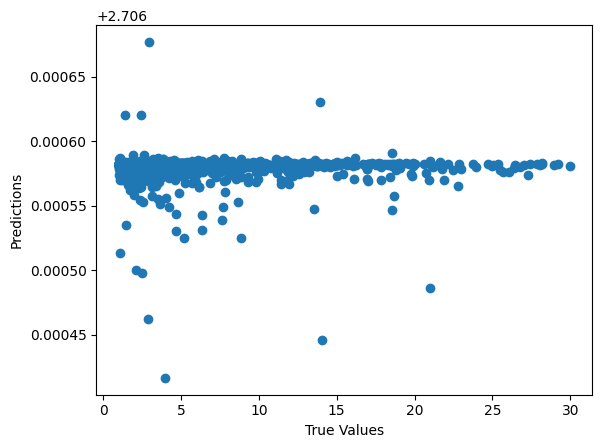

In [ ]:
import matplotlib.pyplot as plt
with torch.inference_mode():
  y_preds_los , y_preds_mort = model(X_test)
  plt.scatter(y_test_los, y_preds_los)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.show()

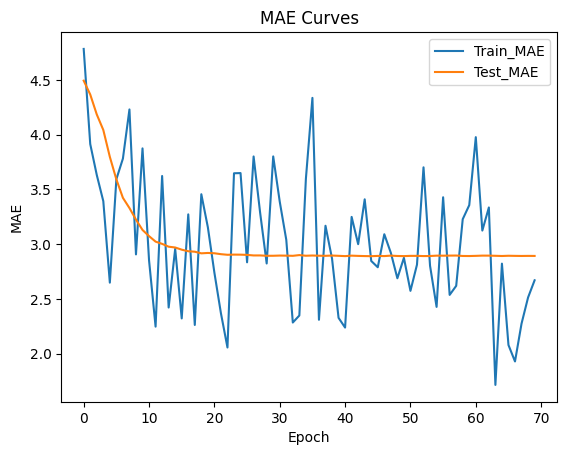

In [ ]:
# Plotting
plt.plot(epoch_count, MSE_values, label = "Train_MAE")
plt.plot(epoch_count, test_MSE_values, label = "Test_MAE")
plt.title("MAE Curves")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend()

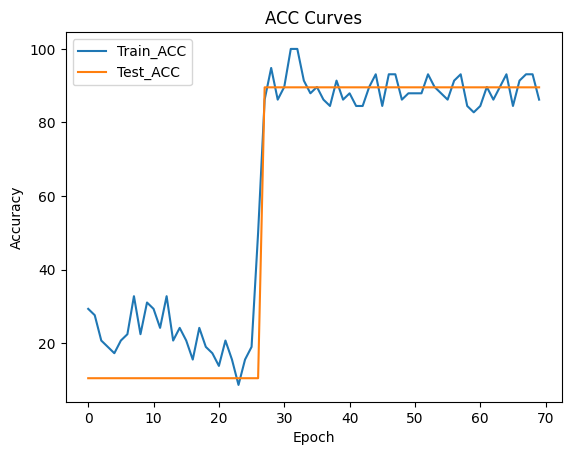

In [ ]:
# Plotting
plt.plot(epoch_count, ACC_values, label = "Train_ACC")
plt.plot(epoch_count, test_ACC_values, label = "Test_ACC")
plt.title("ACC Curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

In [ ]:
model.eval()
with torch.inference_mode():
  val_preds_los, val_preds_mort = model(X_val)
  print(mean_absolute_error(y_val_los, val_preds_los))
  val_preds_mort = torch.round(torch.sigmoid(val_preds_mort.squeeze()))
  print(accuracy_fn(y_true = y_val_mort,y_pred = val_preds_mort))

2.695005
89.50212273253571


In [ ]:
PATH = '/content/drive/My Drive/Colab Notebooks/TeamShare/Output/'
torch.save(model.state_dict(), PATH)